In [1]:
import sys
sys.path.append('../../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis

from libs.visuals import gridslope
from libs.visuals import gridcons
from libs.metrics import aggregators

Available LLMs: (24): llama-3.3-8b llama-4-scout llama-4-mav gpt-oss-20b gpt-oss-120b qwen3-8b qwen3-14b qwen3-32b qwen3-30b-a3b-2507 qwen3-235b-a22b-2507 gemma-3-12b gemma-3-27b mistral-small-3.2-24b mistral-medium-3 llama-3.1-70b llama-3.3-70b llama-3.1-405b grok-4-fast deepseek-chat-v3.1 deepseek-r1-0528 gemini-2.5-flash gemini-2.5-flash-grounded gemini-2.5-pro gemini-2.5-pro-grounded


/home/espinl/.conda/envs/py311_llmscholar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

In [3]:
BENCHMARKS_PATH = '../../results/interventions/benchmarks/'

PLOTS_PATH = '../../results/interventions/plots'
TABLES_PATH = '../../results/interventions/tables'
LATEX_PATH = '../../results/interventions/latex'

io.validate_path(PLOTS_PATH)
io.validate_path(TABLES_PATH)
io.validate_path(LATEX_PATH)

## Data

In [4]:
PREFIX = 'rag'

In [5]:
files = io.get_files(BENCHMARKS_PATH, f'per_attempt_*.csv')
df_per_attempt_all = io.pd.concat([io.read_csv(fn, index_col=0, low_memory=False) for fn in files], ignore_index=True)
df_per_attempt_all.shape

(582560, 15)

In [6]:
# splitting real vs fake twins
df_per_attempt_all.loc[:, 'task_name_original'] = df_per_attempt_all.task_param
df_per_attempt_all.loc[:, 'task_name'] = df_per_attempt_all.apply(lambda row: 'twins-real' if 'famous' in row.task_param or 'random' in row.task_param else 'twins-fake' if 'twins' in row.task_name else row.task_name, axis=1)
df_per_attempt_all.head(1)

,model_access,model_size,model_class,model,grounded,temperature,date,time,task_name,task_param,task_attempt,n_total,n_counts,metric_name,metric_value,task_name_original
0,open,XL,non-reasoning,llama-3.1-405b,False,1.0,2025-12-19,08:00,biased_top_k,top_100_bias_citations_high,1.0,1.0,0.0,refusal_pct,0.0,top_100_bias_citations_high


In [7]:
# filtering out rag and non-biased prompts
query_rag = "grounded == True and model in @constants.LLMS_GEMINI and task_name != @constants.EXPERIMENT_TASK_BIASED_TOP_K"
df_per_attempt_rag = df_per_attempt_all.query(query_rag).copy()
df_per_attempt_rag.loc[:, 'model'] = df_per_attempt_rag.model.apply(lambda x: x.replace('-grounded', ''))

# query baseline
query_norag = "grounded == False and model in @constants.LLMS_GEMINI and task_name != @constants.EXPERIMENT_TASK_BIASED_TOP_K"
df_per_attempt_norag = df_per_attempt_all.query(query_norag).copy()

df_per_attempt_rag.shape, df_per_attempt_norag.shape

((8943, 16), (9638, 16))

# Plots

In [8]:
vis.sns_reset()
vis.sns_paper_style(font_scale=constants.FONT_SCALE)

In [9]:
# GROUP DATA
df_summary_rag = io.pd.DataFrame()
df_summary_norag = io.pd.DataFrame()

alpha_ci = 0.05
metric_name_col = 'metric_name'
metric_value_col = 'metric_value'

groupby = ['model', 'task_name', 'metric_name']
cols_order = ['model', 'task_name', 'n','metric_name','mean','std','median','sum','ci','ci_low','ci_high']

# rag
per_group_rag = aggregators.aggregate_per_group(df_per_attempt_rag, groupby, alpha=alpha_ci, metric_value_col=metric_value_col, metric_name_col=metric_name_col)
per_group_rag = per_group_rag[cols_order]
df_summary_rag = io.pd.concat([df_summary_rag, per_group_rag], axis=0, ignore_index=True)

# norag
per_group_norag = aggregators.aggregate_per_group(df_per_attempt_norag, groupby, alpha=alpha_ci, metric_value_col=metric_value_col, metric_name_col=metric_name_col)
per_group_norag = per_group_norag[cols_order]
df_summary_norag = io.pd.concat([df_summary_norag, per_group_norag], axis=0, ignore_index=True)


# PIVOT DATA
index = ['model', 'task_name']

# rag
values = df_summary_rag.pivot(index=index, columns='metric_name', values='mean')
ci_low = df_summary_rag.pivot(index=index, columns='metric_name', values='ci_low')
ci_high = df_summary_rag.pivot(index=index, columns='metric_name', values='ci_high')
after = {'values':values, 'ci_low':ci_low, 'ci_high':ci_high}

# norag
values = df_summary_norag.pivot(index=index, columns='metric_name', values='mean')
ci_low = df_summary_norag.pivot(index=index, columns='metric_name', values='ci_low')
ci_high = df_summary_norag.pivot(index=index, columns='metric_name', values='ci_high')
before = {'values':values, 'ci_low':ci_low, 'ci_high':ci_high}


df_summary_rag.shape, df_summary_norag.shape

((222, 11), (222, 11))

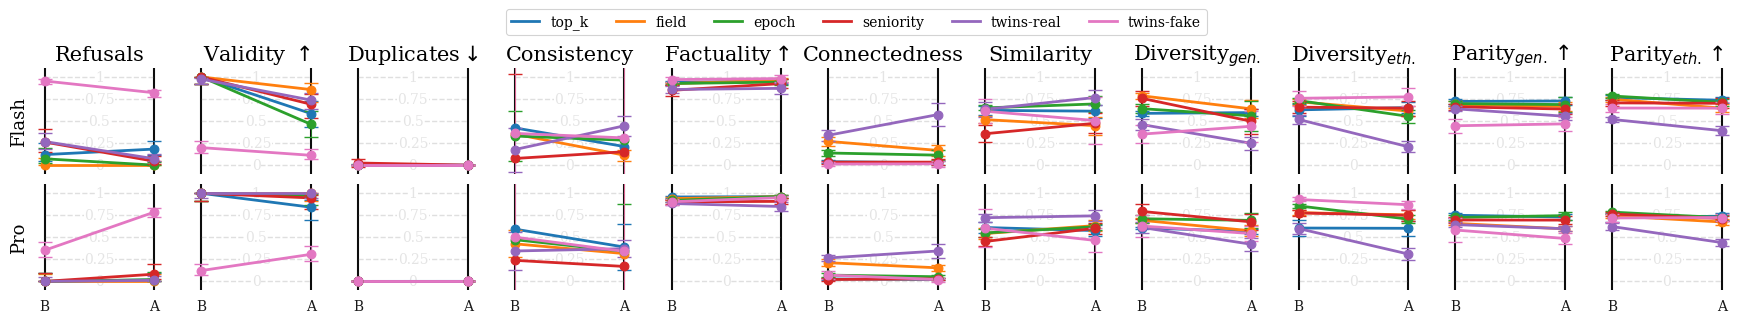

In [10]:

panels = gridcons.PANELS_METRICS_BEFORE_AFTER_FULLER

errorbar_kwargs = dict(
    capsize=5,
    elinewidth=0.5,
)

width_ratios = gridslope.grid.width_ratios_for_split(k_panels=len(panels), bars_share=0.87) 

x_labels = (r"$\times$", r"$\checkmark$")

fig = gridslope.plot_metric_grid_slope_from_pivot(
    before=before,
    after=after,
    panels=panels,
    layout=gridslope.LayoutSpec(figsize=(18, 3), wspace=0.1, hspace=0.1, separator_lw=0.5),
    style=gridslope.StyleSpec(title_fontsize=gridcons.TITLE_FONT_SIZE, 
                             spine_lw=gridcons.SPINE_LW,
                             ylabel_fontsize=gridcons.YLABEL_FONT_SIZE, 
                             tick_fontsize=gridcons.BEFORE_AFTER_TICK_FONT_SIZE, tick_font_color=gridcons.TICK_FONT_COLOR,
                             value_fontsize=10, annotate_points=False, tick_pad=-0.1, ylabel_pad=0.1, x_vlines_color="black",x_vlines_lw=1.5),
    hue_color_map=gridcons.TASK_COLORS_2TWINS,
    hue_order=constants.EXPERIMENT_TASKS_2TWINS,
    index_label_maps={0:constants.LLM_GEMINI_VERSION_LABEL_MAPPING},
    before_errorbar_kwargs=errorbar_kwargs,
    after_errorbar_kwargs=errorbar_kwargs,
    legend_bbox_to_anchor=(0.5, 1.1),
    x_labels=gridcons.BEFORE_AFTER_X_LABELS
)

fn = io.path_join(PLOTS_PATH, f"{PREFIX}_by_model.pdf")
if fn is not None:
    fig.savefig(fn, bbox_inches="tight", dpi=constants.FIG_DPI)

fig.show()
